In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import defaultdict, OrderedDict


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kively/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kively/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def read_file(filename, col_names):
    return pd.read_csv(filename, sep='\t', header=None, names=col_names)


def preprocessing(data, flag_remove, flag_stem): #data: list of passages 
    """
    Preprocess the passages tokenizing each sentence, converting to lower case, excluding non alphabetic words
    removing stopwords and stemming
    
    :param data:                list of strings (passages) 
    :param flag_remove:         True to remove stop words
    :param flag_stem:           True to convert to stems
    :return:                    a list of lists with the tokens of each passage
    """
    stop_words = set(stopwords.words('english'))
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = PorterStemmer()
    processed_sentences = []

    for sentence in data:
        # tokenize each sentence
        try: 
            tokenized_sentence = tokenizer.tokenize(sentence)
        except: 
            print(sentence)
            return None
        
        # convert to lower case
        sentence = [w.lower() for w in tokenized_sentence]

        # exclude non alphabetic words
        only_alpha_sentence = [word for word in sentence if word.isalpha()]
        
        # remove stop words
        if flag_remove:
            filtered_sentence = [w for w in only_alpha_sentence if w not in stop_words]
        else:
            filtered_sentence = only_alpha_sentence

        tokenized_sentence = []

        if flag_stem:
            # stemming
            for word in filtered_sentence:
                tokenized_sentence.append(stemmer.stem(word))
        else:
            tokenized_sentence = filtered_sentence

        processed_sentences.append(tokenized_sentence)
   
    return processed_sentences
#list of lists (comprised of tokens)

def term_frequencies(passages):  #Q1 (only)
    """
    Finds the frequencies of tokens in a list of passages. Each passage is a list of tokens.

    :param passages:            list of passages
    :return:                    a sorted dict of term frequencies and the total number of words
    """
    dictionary = {}
    no_of_words = 0
    for passage in passages:
        for token in passage:
            if token not in dictionary:
                dictionary[token] = 1
            else:
                dictionary[token] += 1
            no_of_words += 1

    # sort by decreasing order for Zipf's law
    sorted_dictionary = sorted(
        dictionary.items(),
        key=lambda item: item[1],
        reverse=True
    )
    return sorted_dictionary, no_of_words


<h3>Subtask 1</h3>
<ul>
    <li>Read all passages</li>
    <li>Preprocess passages</li>
    <li>Calculate term frequencies</li>
    <li>Find the exponent in Zipf's law using the first 1000 ranks</li>
    <li>Plot probability of occurence vs rank and real data with predicted from linear regression</li>
</ul>
    

In [4]:
# Q1
# Read all passages
set_01 = read_file("datasets/passage_collection_new.txt", ['Passage'])
docs = preprocessing(list(set_01.Passage), False, False) #zipfs law 

freqs, total_words = term_frequencies(docs)
print(freqs)
freqs = np.array([x[1] for x in freqs])
trial=np.sum(freqs)
print(trial)

#Q1 Report the values of the parameters for Zipf's Law for this collection\n",
max_rank = 1000
log_rankings = np.log10(np.arange(1, max_rank + 1)).reshape(-1,1)
log_frequencies = np.log10(freqs[:max_rank]).reshape(-1,1)
regression = LinearRegression().fit(log_rankings, log_frequencies)
coefficient = regression.coef_
intercept = regression.intercept_
print("coefficient of regression", coefficient)
print("intercept of regression",intercept)
#y=c*x^γ 
#γ=-1 theoretical value
#-0.86 close to -1 


[('the', 626892), ('of', 334283), ('a', 283558), ('and', 255211), ('to', 240943), ('is', 216851), ('in', 202175), ('for', 108167), ('or', 86924), ('you', 86652), ('that', 81084), ('are', 77176), ('it', 69548), ('on', 68236), ('as', 67752), ('your', 61565), ('with', 59497), ('s', 56348), ('by', 52045), ('an', 50108), ('can', 49971), ('be', 49110), ('from', 47956), ('this', 43533), ('at', 39432), ('have', 33377), ('not', 31856), ('if', 30447), ('will', 27760), ('one', 27299), ('was', 27110), ('which', 25851), ('name', 25102), ('i', 23897), ('more', 23607), ('has', 23295), ('also', 21757), ('but', 21569), ('when', 21533), ('number', 21351), ('all', 20578), ('may', 20556), ('other', 19958), ('most', 19822), ('about', 18979), ('they', 18620), ('there', 17480), ('cost', 17128), ('how', 16568), ('used', 16542), ('than', 16226), ('first', 16111), ('what', 15968), ('blood', 15117), ('up', 14957), ('time', 14887), ('meaning', 14488), ('t', 14356), ('use', 14120), ('some', 13977), ('years', 13896

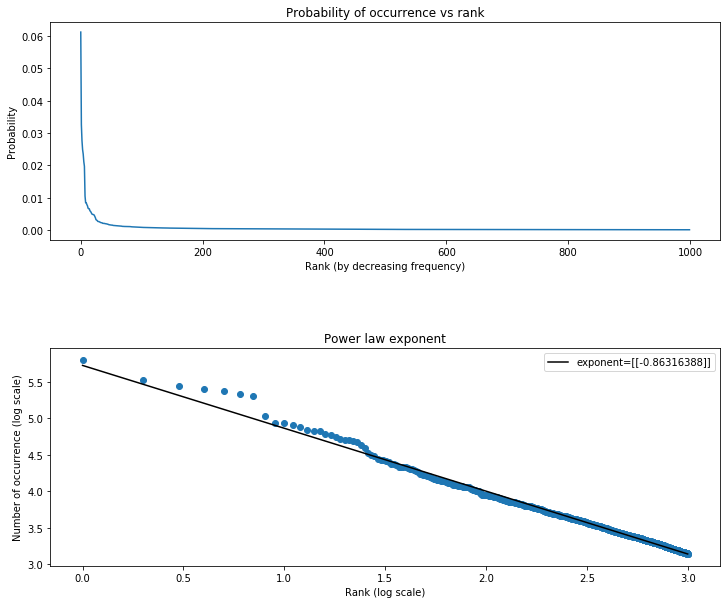

In [5]:
f, ax = plt.subplots(2, 1)
ax[0].plot(freqs[:max_rank] / total_words)
ax[0].set_title('Probability of occurrence vs rank')
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("Rank (by decreasing frequency)")

y_pred = regression.predict(log_rankings)
ax[1].scatter(log_rankings, log_frequencies)
l1, = ax[1].plot(log_rankings, y_pred, color='k')
ax[1].set_title("Power law exponent")
ax[1].set_xlabel("Rank (log scale)")
ax[1].set_ylabel("Number of occurrence (log scale)")
ax[1].legend([l1], ["exponent={}".format(coefficient)])
plt.subplots_adjust(hspace=0.5)
f.set_size_inches(12, 10)
plt.show()


In [15]:
#it is called only once: for each query, gives the list of candidate passages 

def build(queries_file, candidates_file):
    """
    Builds data structures based on a set of queries and a list of candidate passages for each query

    :param queries_file         a file with query id and query text
    :param candidates_file:     a file with query id, passage id, query text and passage text
    :return:                    3 dictionaries:
                                1. query id -> list of candidate passage ids (q_p)
                                2. query id -> clean list of query tokens (q_c)
                                3. passage id -> clean list of passage tokens (p_c)
    """
    f1 = read_file(queries_file, ['q_id', 'q_text'])
    f2 = read_file(candidates_file, ['q_id', 'p_id', 'q_text', 'p_text'])
    q_p = dict(
        (
            qid,
            list(f2.p_id[f2.q_id == qid])
        ) for qid in f1.q_id
    )

    q_c = dict(
        (
            f1.q_id.iloc[j],
            preprocessing([f1.q_text.iloc[j]], True, True)[0]
        ) for j in range(len(f1)) #for all the rows of the f1 matrix (matrix containing all the queries)
        
    )
    
    idx = [p.index[0] for _, p in f2.groupby(["p_id"])] #f2 pinakas, group according to the containt of the column 
    #list: contains the positions of passage ids when these occur for the first time 
    
    
    #group the positions of the same passage id together
    unique_pids = list(f2.p_id.iloc[idx]) #a passage can be found in more than one positions, list of passages  
    tokens = list(f2.p_text.iloc[idx]) 
    tokens = preprocessing(tokens, True, True) #tokens= passages 
    p_c = dict(zip(unique_pids, tokens)) #passage ids: keys, values= list of tokens
    #zip: takes 2 lists of the same length and creates a list of tuples   
    return q_p, q_c, p_c





def inv_idx(passages, filtered_pids=None): #from the collection of all the passages, select some of them(filtered_pids)
    #passages: all the passages of the collection(p_c)
    """
    Given a dict of passage id -> passage tokens, creates an inverted index from a selected set of passages.

    :param passages:            dict passage id -> passage tokens (list)
    :param filtered_pids:       set of passage ids to account for or None for all
    :return:                    a dict with token -> dict { passage id -> list of positions }
    """
    #we dont store the frequency of the token, but the position in which it occurred in the document 
    #so we take the frequency of that token by taking the langth of the list of positions
    
    if filtered_pids is None:
        filtered_pids = passages.keys()

    i_id = {}
    for pid in filtered_pids: 
        token_position = 0
        for token in passages[pid]: #token in one document (pasage)
            if token not in i_id.keys():
                i_id[token] = {pid: [token_position]} 
            else:
                try:
                    i_id[token][pid].append(token_position)  #append the token's position in the list 
                except KeyError: #it does not exist (except)
                    i_id[token][pid] = [token_position] #lista in which the first element is the token's position
            token_position += 1 #each token is added to the list  
    return i_id

#inv index for a subset of passages! (inv index specific to a query)

<h3>Subtask 2</h3>
<ul>
    <li>Build the following dicts:
        <ul>
            <li>q_p with querry id -> list of candidate passage ids</li>
            <li>q_c with query id -> list of query tokens (cleaned)</li>
            <li>p_c with passage id -> list of passage tokens (cleaned)</li>
        </ul>
    </li>
    <li>Build dict q_i_id as:

            q_i_id = {
                query id: { #inv index dictionary
                    token: {
                        passage id: list of token positions in passage
                    }
                }
            }
</li>
</ul>

In [7]:
q_p, q_c, p_c = build("datasets/test-queries.tsv", "datasets/candidate_passages_top1000.tsv") #create
print(q_p)
print(q_c)
print(p_c)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
#trials 
q_id = 1108939
p_id = 8406305

In [9]:
#all the inverted index structures for all the queries
q_i_id = {}
filter_qids = q_c.keys()  # q_c.keys() for all queries or a list of selected query ids
for _id in filter_qids: #we give all the query IDs 
    # Here we will calculate the inverted index based only on the candidate passages for the specific query
    q_i_id[_id] = inv_idx(p_c, q_p[_id]) #p_c: all the passages, but we give the passage IDs which correspond to the query we are handling via the filtering 
    #q_p: candidate passages of the specific query id

In [10]:
#trial
#q_i_id[q_id]['studi']
#from the inverted index of the q_id, it prints the contents of the token "studi"
#in which positions the token "studi" has appeared 
print(q_i_id[q_id])


#at this point we have all the inverted indices, and the three initial dictionaries 


{'studi': {8406305: [0], 7371584: [11], 6299786: [17], 3425982: [13], 7919417: [0, 5, 27, 32], 3632434: [0, 5], 2952048: [16], 1011004: [27], 6092801: [0], 8692484: [21], 8494655: [0, 5], 3899060: [17, 25, 31, 40, 49, 96, 104], 3092483: [1], 2834912: [18], 1199019: [24, 29], 8096932: [21, 26], 8177653: [0], 2352633: [0, 5], 945235: [29], 424843: [2], 4457901: [0, 5], 7804766: [14, 19]}, 'high': {8406305: [1], 5182924: [20], 8596281: [19, 41], 7491705: [18], 5493204: [2], 978962: [15], 6643891: [7], 3058067: [21], 3259017: [0, 39], 7919347: [25], 3615744: [19], 3647358: [25, 89], 2604588: [9], 1546127: [18], 1734818: [22], 528263: [5, 21, 34, 50], 532318: [34], 2960283: [3, 28], 8596285: [7, 38, 48], 8725053: [13], 7340851: [6, 11], 7428365: [24, 27], 4251218: [8], 528262: [4, 20, 33, 49], 5353484: [57], 536817: [3], 1231448: [0], 6434632: [13], 4835505: [8], 3750344: [5], 1199019: [6], 5748454: [11, 41], 1244324: [31], 1406041: [9, 36], 5156296: [34], 457353: [0, 44], 457358: [40], 768

In [19]:
def tf_idf_representation(passages, inverted_index_dict, filtered_pids=None, n=None):
    #For each token of the passage, it stores the tf-idf score in a vector (via a dictionary data structure)
    #we keep only the non-zero values
    
    #passages:p ids to p tokens (dict): we give all the passages, but we rule out the irrelevant ones via the filtered_pids
    #inv index: to extract frequencies 
    #filtered pids: for the passages relevant to the specific query ID
    #n: total number of passages 
    #n=none: it will be exactly as many as the filtered_pids
    
    """
    Calculates the tf_idf vector representation of a set of passages.
    
    :param passages:            dict passage id -> passage tokens (list)
    :param inverted_index_dict: the inverted index of passages
    :param filtered_pids:       the selected set of passage ids to account for
    :param n:                   the total number of passages (if None then the total passages are the filtered ones)
    :return:                    a dict with passage_id -> dict {token -> tf_idf score}
    """
    if filtered_pids is None:
        filtered_pids = passages.keys()
    if n is None:
        n = len(filtered_pids)

    tf_idf = {}
    for p_id in filtered_pids: 
        tf_idf[p_id] = {}
        d_l= len(passages[p_id]) #division at the tf term
        for token in passages[p_id]:
            if token in tf_idf[p_id].keys():
                # We are here because the token is in multiple psotions in the passage and we have already count it
                continue
            tf = len(inverted_index_dict[token][p_id])/d_l  # how many times the token is in passage
            idf = np.log10(n / len(inverted_index_dict[token])) 

            tf_idf[p_id][token] = tf*idf
            #key,value: vector representation
    
    return tf_idf


def cosine_similarity(vector_1, vector_2):
    #similarity between query and a passage
    #only the common keys of the 2 vectors are multiplied

    """
    Calculates the cosine of two vectors. The vectors are dictionaries, so the inner product is based
    on common keys
    
    :param vector_1:           dict representation of first vector
    :param vector_2:           dict representation of second vector
    :return:                   the cosine of the angle of two vectors
    """
    k1 = set(list(vector_1.keys())) #take the keys, make them a set and then take the unique
    k2 = set(list(vector_2.keys()))
    common_keys = k1 & k2 #intersection of the keys, takes only the common
    inner_product = 0
    for key in common_keys:
        inner_product += vector_1[key] * vector_2[key]
    
    norm_1 = np.linalg.norm(list(vector_1.values())) 
    norm_2 = np.linalg.norm(list(vector_2.values()))
    
    return inner_product / (norm_1 * norm_2) #all the keys 


def BM_25(
    query,
    p_id,
    p_tokens,
    inverted_index_dict,
    av_len,
    N,
    k1=1.2,
    k2=100,
    b=0.75
):
    """
    Calculates the BM25 score of a given query with a given passage
    
    :param query:               the query list of tokens
    :param p_id:                the passage id (for use with inverted index)
    :param p_tokens:            the passage list of tokens
    :param inverted_index_dict: the inverted index of tokens
    :param av_len:              average document length
    :param N:                   the total number of passages
    :param k1:                  the k1 parameter
    :param k2:                  the k2 parameter
    :param b:                   the b parameter
    :return:                    the BM 25 score
    """
    dl = len(p_tokens)
    K = k1 * ((1 - b) + b * dl / av_len)
    score = 0

    for token in query:
        try:
            n_i = len(inverted_index_dict[token]) #if the token does not exist in any of the documents, it will also not appear in the inverted index 
        except KeyError:
            # We are here because the query token does not exists in any passage: edw xtipaei to exception
            n_i = 0 #number of documents in which we encounter the token
        # check whether qf is indeed 1
        qf = 1 #assuming each token appears only once in the specific query
        try:
            f_i = len(inverted_index_dict[token][p_id])
        except KeyError:
            f_i = 0

        score += np.log((N - n_i + 0.5) / (n_i + 0.5) * (k1 + 1) * f_i / (K + f_i) * (k2 + 1) * qf / (k2 + qf))
        
    return score
#when the number n_i is > N/2 then the argument of the logarithm is <1 so the logarithm becomes negative


In [20]:
#test whether a token exists multiple times in a specific query
for q_id, q_text in q_c.items():
    test= set(q_text)
    if len(q_text) != len(test):
        print(q_id)
        

264403
1133418
1014126
523270
1059231


<h3>Subtask 3</h3>
<ul>
    <li>Foreach query, calculate the vector representation of each passage (from candidate ones)</li>
    <li>Find the cosine of the angle between the passage vector and the query vector</li>
    <li>Find the BM25 score of each passage</li>
    <li>Sort scores and save the 100 best</li>
</ul>

In [21]:
f_vs = open("results/VS.txt", 'w') #output files 
f_bm25 = open("results/BM25.txt", 'w')
for q_id in q_p.keys():
    # First calculkate the vector representation of the passages
    p_vectors = tf_idf_representation(p_c, q_i_id[q_id], filtered_pids=q_p[q_id]) #representation of passages, performs filtering (passages of the specific query)
    print("Q_ID:\t{:10d},\tTotal passages:\t{}".format(q_id, len(p_vectors)))
    
    # Calculate the vector representation of the query
    q_vec={}
    #count how many times each token of the query exists in the query
    
    for token in q_c[q_id]: #tokens of the specific query
        try:
            q_vec[token] += 1 #if we encounter it again, we increase it 
        except KeyError:
            q_vec[token] =1 #we found it once, we initialise it
        #vector representation of the query: (key,value)
       
    
    # Initialize dicts
    scores_tf_idf = {} 
    scores_bm25 = {}
    
    # Loop for every passage (candidate passage for each specific query)
    for pid, pvec in p_vectors.items():  #the tfidf vector repres, (pid, vector repres)
        # Calculate scores
        scores_tf_idf[pid] = cosine_similarity(pvec, q_vec)
        scores_bm25[pid] = BM_25(
            q_c[q_id],
            pid,
            p_c[pid], #tokens (specific)
            q_i_id[q_id], #inv index (specific)
            np.mean([len(p_c[x]) for x in q_p[q_id]]), #length of docs in the collection 
            #for each passage x, it creates a list with length this of x, it takes in general 1000 values and takes the length of this list
            len(q_p[q_id]), #number of docs(N), each time is computed for the query at hand
            k1=1.2,
            k2=100,
            b=0.75
        )
    # Sort scores by decreasing order
    scores_tf_idf = sorted(scores_tf_idf.items(), key=lambda x: x[1], reverse=True) #dict
    scores_bm25 = sorted(scores_bm25.items(), key=lambda x: x[1], reverse=True) #dict 

    # Keep only the 100 first scores and write them to files
    #stores the minimum number, otherwise it stores 1000 (number of passages most of the queries have)
    #this handles the situation of having queries with less than 1000 passages
    #if scores are more than 100, we take 100 otherwise the minimum number
    
    for j in range(min(100, len(scores_tf_idf))):
        f_vs.write(
            "{}\tA1\t{}\t{}\t{}\tVS\n".format(
                q_id,
                scores_tf_idf[j][0],
                j + 1,
                scores_tf_idf[j][1]
            )
        )
        f_bm25.write(
            "{}\tA1\t{}\t{}\t{}\tBM25\n".format(
                q_id,
                scores_bm25[j][0],
                j + 1,
                scores_bm25[j][1]
            )
        )

# Do not forget to close the files
f_vs.close()
f_bm25.close()
#comment : number of documents is small

Q_ID:	   1108939,	Total passages:	1000


<ipython-input-19-8820cc405905>:109: RuntimeWarning: divide by zero encountered in log
  score += np.log((N - n_i + 0.5) / (n_i + 0.5) * (k1 + 1) * f_i / (K + f_i) * (k2 + 1) * qf / (k2 + qf))


Q_ID:	   1112389,	Total passages:	999
Q_ID:	    792752,	Total passages:	12
Q_ID:	   1119729,	Total passages:	1000
Q_ID:	   1105095,	Total passages:	1000
Q_ID:	   1105103,	Total passages:	1000
Q_ID:	   1128373,	Total passages:	1000
Q_ID:	   1127622,	Total passages:	1000
Q_ID:	   1124979,	Total passages:	1000
Q_ID:	    885490,	Total passages:	1000
Q_ID:	   1119827,	Total passages:	1000
Q_ID:	    190044,	Total passages:	1000
Q_ID:	    500575,	Total passages:	1000
Q_ID:	    883785,	Total passages:	1000
Q_ID:	    264403,	Total passages:	1000
Q_ID:	   1108100,	Total passages:	1000
Q_ID:	    421756,	Total passages:	1000
Q_ID:	   1108307,	Total passages:	1000
Q_ID:	    966413,	Total passages:	1000
Q_ID:	   1111546,	Total passages:	1000
Q_ID:	    156493,	Total passages:	1000
Q_ID:	   1124145,	Total passages:	1000
Q_ID:	   1110199,	Total passages:	1000
Q_ID:	   1056204,	Total passages:	1000
Q_ID:	    199143,	Total passages:	1000
Q_ID:	    835929,	Total passages:	1000
Q_ID:	   1063750,	Total pass

In [22]:
def smoothing(query, p_id, inverse_index_dict, d_len, method="laplace", **kwargs):
    #inverted index: to find all the frequencies 

    #depending on the method, we need some parameters 
    # ** : an opened dictionary of the form: key=value
    #kwargs: as dictionary
    """
    Calculates the smoothed probability that the query tokens exist in the document.
    
    :param query:               the list of query tokens (cleaned)
    :param p_id:                the passage id to account for
    :param inverse_index_dict:  the inverse index of tokens
    :param d_len:               the passage length
    :param method:              the method to use for smoothing. Accepted values are: laplace, lindstone, dirichlet
    :param **kwargs:            a list of key -> values specific for each method. These keys are:
                                key        description           used in
                                -----------------------------------------
                                t_w        total words           dirichlet
                                epsilon    constant              lindstone
                                mu         constant              dirichlet
    """
    if method in ["laplace", "lindstone"]:
        epsilon = kwargs.get("epsilon", 0.5) if method == "lindstone" else 1 #at the kwards dictionary
        # We have to calculate the vocabulary size
        v_len = len(inverse_index_dict) #length of dictionary, query-specific 
        score = 0.0
        for token in query:
            try:
                score += np.log10(epsilon + len(inverse_index_dict[token][p_id]))
                #product of vary small numbers (probabilities <1)
                #we treat them as logarithms
            except KeyError:
                continue
        return score - v_len * np.log10(d_len + epsilon * v_len)
    #log(a/b) = loga-logb  denominator is the same for all the passages 
    
    if method == "dirichlet":
        mu = kwargs.get("mu", 2000)
        try:
            t_w = kwargs["t_w"]
        except KeyError:
            raise ValueError("missing value for total words -> t_w")
        # We need to calculate the total word occurences t_w
        score = 0.0
        lmda = d_len / (d_len + mu)
        for token in query:
            try:
                fqi = len(inverse_index_dict[token][p_id]) #token frequecy at the passage
            except KeyError:
                fqi = 0.0
            try:
                cqi = np.sum([len(inverse_index_dict[token][_p_id]) for _p_id in inverse_index_dict[token].keys()])
                #number of occurrences of the token in the whole collection (for all the documents in the collection)
            except KeyError:
                cqi = 0.0

            score += np.log10(lmda * fqi / d_len + (1 - lmda) * cqi / t_w) #d_len: number of words in the passage we are considering 
        return score 
    raise ValueError("method {} is not supported".format(method)) #if the method is none of the above, it throws an exception
        

In [23]:
f_lap = open("results/LM-Laplace.txt", 'w')
f_lind = open("results/LM-Lindstone.txt", 'w')
f_dir = open("results/LM-Dirichlet.txt", 'w')
#open the files with the results

for q_id in q_p.keys(): #for all the queries
    v_len = len(q_i_id[q_id]) #voc length: number of tokens that exists in the inverted index of the specific query 
    #v_len: laplace, lindstone
    #voc length: each word we count only once 
    t_w = [
        sum([
            len(q_i_id[q_id][token][_p_id]) for _p_id in q_i_id[q_id][token] #sum of all the words, not only the unique
            #for each doc: p_id , how many times the token exists in the passage id 
        ]) for token in q_i_id[q_id].keys() #first for loop : takes the unique tokens 
    ] #sum : adds all the occurrences 
    #second for: for all the passage ids
    #total words: total number of words
    
    t_w = np.sum(np.array(t_w).flatten())  #t_w: dirichlet 

    scores_laplace = {}
    scores_lindstone = {}
    scores_dirichlet = {}
    for p_id in q_p[q_id]:
        scores_laplace[p_id] = smoothing(
            q_c[q_id], p_id, q_i_id[q_id], len(p_c[p_id]), method="laplace"
        ) #p_c:m passages cleaned
        scores_lindstone[p_id] = smoothing(
            q_c[q_id], p_id, q_i_id[q_id], len(p_c[p_id]), method="lindstone", epsilon=0.5
        )
        scores_dirichlet[p_id] = smoothing(
            q_c[q_id], p_id, q_i_id[q_id], len(p_c[p_id]), method="dirichlet", mu=2000, t_w=t_w
        )
    
    scores_laplace = sorted(scores_laplace.items(), key=lambda x: x[1], reverse=True)
    scores_lindstone = sorted(scores_lindstone.items(), key=lambda x: x[1], reverse=True)
    scores_dirichlet = sorted(scores_dirichlet.items(), key=lambda x: x[1], reverse=True)
    
    for j in range(min(100, len(scores_laplace))):
        f_lap.write(
            "{}\tA1\t{}\t{}\t{}\tLM-Laplace\n".format(
                q_id,
                scores_laplace[j][0],
                j + 1,
                scores_laplace[j][1]
            )
        )
        f_lind.write(
            "{}\tA1\t{}\t{}\t{}\tLM-Lindstone\n".format(
                q_id,
                scores_lindstone[j][0],
                j + 1,
                scores_lindstone[j][1]
            )
        )
        f_dir.write(
            "{}\tA1\t{}\t{}\t{}\tLM-Dirichlet\n".format(
                q_id,
                scores_dirichlet[j][0],
                j + 1,
                scores_dirichlet[j][1]
            )
        )

# Do not forget to close files
f_lap.close()
f_lind.close()
f_dir.close()
     

<ipython-input-22-491b2c266a4a>:57: RuntimeWarning: divide by zero encountered in log10
  score += np.log10(lmda * fqi / d_len + (1 - lmda) * cqi / t_w) #d_len: number of words in the passage we are considering
